<a href="https://colab.research.google.com/github/AtrCheema/AI4Water/blob/dev/examples/paper/customizing_loss_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to customize loss function when using AI4Water's `Model` class.

AI4Water's Model class has a method named `loss`. Therefore, if the user wishes to modify loss function for neural networks based models, the user has to overwrite this method of Model class.

In this problem, instead of predicted actual observation, we predict quantiles

The loss value function is customized. We use pinball loss. https://www.lokad.com/pinball-loss-function-definition

Inspired from https://www.kaggle.com/ulrich07/quantile-regression-with-keras

In [1]:
try:
    import ai4water
except (ImportError, ModuleNotFoundError):
    !python -m pip install "AI4Water[all] @ git+https://github.com/AtrCheema/AI4Water.git"

In [2]:
import tensorflow as tf
from tensorflow import keras

tf.__version__

d:\c\anaconda3\envs\tfcpu21_py37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
d:\c\anaconda3\envs\tfcpu21_py37\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
d:\c\anaconda3\envs\tfcpu21_py37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


'2.1.0'

In [3]:
import numpy as np
import pandas as pd

np.__version__

'1.19.1'

In [4]:
from ai4water import Model

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


d:\c\anaconda3\envs\tfcpu21_py37\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



**********Pytorch models could not be imported **********



In [5]:
class QuantileModel(Model):

    def training_data(self, *args, **kwargs):
        x,y = super().training_data(*args, **kwargs)
        return x, y.reshape(-1,1,1)

    def validation_data(self, *args, **kwargs):
        x,y = super().training_data(*args, **kwargs)
        return x, y.reshape(-1,1,1)

    def test_data(self, *args, **kwargs):
        x,y = super().training_data(*args, **kwargs)
        return x, y.reshape(-1,1,1)

    def loss(self):

        return qloss

In [6]:
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = quantiles
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q * e, (q - 1) * e)
    return keras.backend.mean(v)

In [11]:
# Define a dummy dataset consisting of 6 time-series.
rows = 2000
cols = 6
data = np.arange(int(rows*cols)).reshape(-1, rows).transpose()
data = pd.DataFrame(data, columns=['input_' + str(i) for i in range(cols)],
                    index=pd.date_range('20110101', periods=len(data), freq='H'),
                   dtype=float)

# Define Model
layers = {'Dense_0': {'config':  {'units': 64, 'activation': 'relu'}},
          'Dropout_0': {'config':  {'rate': 0.3}},
          'Dense_1': {'config':  {'units': 32, 'activation': 'relu'}},
          'Dropout_1': {'config':  {'rate': 0.3}},
          'Dense_2': {'config':  {'units': 16, 'activation': 'relu'}},
          'Dense_3': {'config':  {'units': 9}},
          'Reshape': {"target_shape": (9, 1)}
         }

ERROR! Session/line number was not unique in database. History logging moved to new session 24885


In [12]:
# Define Quantiles
quantiles = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]

In [13]:
# Initiate Model
model = QuantileModel(
    input_features=['input_' + str(i) for i in range(cols - 1)],
    output_features=['input_' + str(cols - 1)],
    #lookback=1,
    model={'layers': layers},
    epochs=10,
    quantiles=quantiles)

building DL model for  regression problem using QuantileModel
Model: "quantile_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
Dense_0 (Dense)              (None, 64)                384       
_________________________________________________________________
Dropout_0 (Dropout)          (None, 64)                0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
Dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
Dense_2 (Dense)              (None, 16)                528       
______________________________________________________

***** Training *****
input_x shape:  (1280, 5)
target shape:  (1280, 1, 1)
***** Validation *****
input_x shape:  (320, 5)
target shape:  (320, 1, 1)
Train on 1280 samples, validate on 320 samples
Epoch 1/10
assigning name input_1 to IteratorGetNext:0 with shape (32, 5)
assigning name input_1 to IteratorGetNext:0 with shape (32, 5)
1280/1280 [==============================] - 1s 724us/sample - loss: 4036.7103 - nse: -5015.7666 - val_loss: 1789.2893 - val_nse: -1865915.0000
Epoch 2/10
1280/1280 [==============================] - 0s 38us/sample - loss: 1536.6065 - nse: -1025.2112 - val_loss: 368.2747 - val_nse: -65432.5078
Epoch 3/10
1280/1280 [==============================] - 0s 38us/sample - loss: 1070.4763 - nse: -499.1193 - val_loss: 229.2164 - val_nse: -26760.5254
Epoch 4/10
1280/1280 [==============================] - 0s 35us/sample - loss: 1000.2639 - nse: -433.0707 - val_loss: 323.8733 - val_nse: -56826.6875
Epoch 5/10
1280/1280 [==============================] - 0s 35us/sample 

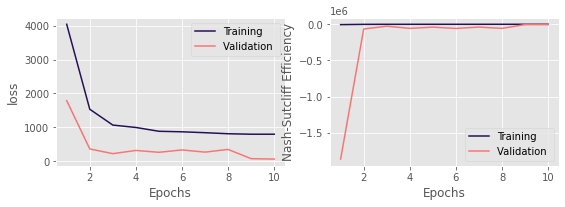

********** Successfully loaded weights from weights_010_70.22583.hdf5 file **********


In [14]:
# Train the model on first 0.6 % of data, while 0.2% of data will be used for validation
h = model.fit(data=data)

We can verify that the model is using the `qloss` function as objective function

In [16]:
model.loss.__name__

'qloss'

In [17]:
true_y, pred_y = model.predict(return_true=True)

***** Test *****
input_x shape:  (400, 5)
target shape:  (400, 1, 1)
assigning name input_1 to IteratorGetNext:0 with shape (None, 5)
400/400 [==============================] - 0s 97us/sample


In [19]:
true_y.shape

(400, 1, 1)

In [20]:
pred_y.shape

(400, 9, 1)